<a href="https://colab.research.google.com/github/pedrohtg/weasel/blob/main/weasel_ft_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo WeaSeL Fine-tuning
In this notebook we will show how to use a pretrained network with the WeaSeL method and fine tune to a new dataset in a few-shot regime.

We will use the OpenIST dataset in the task of lung segmentation.


### Obs: To run this notebook, use a session with GPU

---

Links:

- **Github** : https://github.com/pedrohtg/weasel.git
- **OpenIST** Dataset : https://github.com/pi-null-mezon/OpenIST

In [1]:
# Basic imports
import os
import sys
import torch
from sklearn import metrics
import numpy as np
import random

from torch import optim
from torch.autograd import Variable
# from torch.backends import cudnn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from matplotlib import pyplot as plt

%matplotlib inline

## Step 0:
Install the torchmeta module. Its not necessary for training, but the
network model was implemented using this module.

In [2]:
# %pip install torchmeta

## Step 1:
Clone the source code repo from the link https://github.com/pedrohtg/weasel.git

In [3]:
# !rm -r weasel
# !git clone https://github.com/pedrohtg/weasel.git

## Step 2:
Download and unzip the dataset

In [4]:
# Auxiliar module to download files from Google Drive
# %pip install googledrivedownloader

In [5]:
# from google_drive_downloader import GoogleDriveDownloader as gdd

In [2]:
# gdd.download_file_from_google_drive(file_id='1Z3VlJ8h7EDDeNlsJDP0GrnnQBKM-iUjR',
#                                     dest_path='./openist.zip',
#                                     unzip=True)

# Create a list of tuples (img, mask)
# This will be used below
openist_list = [(f, f.replace('.jpg', '@.png')) for f in os.listdir('openist') if '@' not in f]

## Step 3:
Modify the ListDataset class.

As mentioned in the github repository, this class was implemented following an set folder organization. The dataset we downloaded above, uses a different folder structure, thus we will demonstrate how to easily adapt this class.

There are two main functions that need adaptation, namely, 

```
make_dataset()  # This function generates the list of image files that compose the dataset
get_data()      # This function reads the image, and ground truth files
```
Since, this dataset is composed of grayscale images and binary masks we don't need to modify the `get_data()` function, only the `make_dataset()`.


In [3]:
from data.list_dataset import ListDataset       
from sklearn.model_selection import train_test_split

# We create a new class derived from the original ListDataset
class MyListDataset(ListDataset):
  # The alldata variable will hold all the files in the dataset, we will manually split in train/val sets
  def __init__(self, mode, fold, resize_to, num_shots=5, sparsity_mode='dense', sparsity_param=None, imgtype='med', alldata=None):
    
    # Calling the parent init, note the make=False flag. This flag determines wheter or not the list of images will be generated in the initialization (ie, call the make_dataset function)
    # We set to false, to use our modified version of the make_dataset() function
    super(MyListDataset, self).__init__(mode, 'openist', 'both_lungs', fold, resize_to, num_shots, sparsity_mode, sparsity_param, imgtype, False)

    self.root = 'openist'
    self.alldata = np.array(alldata)
    self.imgs = self.make_dataset()

  def make_dataset(self):
    tr, ts = train_test_split(self.alldata, test_size=0.8, random_state=self.fold, shuffle=False) # Split the data in train/val
    
    # Select split, based on the mode
    data_list = None
    if 'train' in self.mode:
        data_list = tr
    elif 'test' in self.mode:
        data_list = ts

    random.seed(self.fold)
    random.shuffle(data_list)

    # If few-shot, select only a subset of samples
    if self.num_shots != -1 and self.num_shots <= len(data_list):
        data_list = data_list[:self.num_shots]
    
    items = []

    # Creating list containing image and ground truth paths.
    for it in data_list:
        item = (os.path.join(self.root, it[0]), os.path.join(self.root, it[1]))
        items.append(item)
    
    # Returning list.
    return items

## Step 4:

In this step, we create different loaders for multiple few-shot experiments, varying the number of shots and the sparse label paramenters.

In [4]:
# The experiments parameters
list_shots = [1, 5, 10, 20]                                 # Number of shots in the task (i.e, total annotated sparse samples)
list_sparsity_points = [1, 5, 10, 20]                       # Number of labeled pixels in point annotation
list_sparsity_grid = [8, 12, 16, 20]                        # Spacing between selected pixels in grid annotation

In [5]:
# Auxiliar function to generate dataloaders
def get_tune_loaders(shots, points, grid, fold_name, resize_to, args, imgtype='med'):
    data_name = 'openist'
    task_name = 'both_lungs' 
    # Tuning and testing on sparsity mode 'points'.
    points_loader = []
    for n_shots in shots:
        for sparsity in points:
            
            tune_train_points_set = MyListDataset('tune_train', fold_name, resize_to, num_shots=n_shots, sparsity_mode='points', sparsity_param=sparsity, imgtype=imgtype, alldata=openist_list)
            tune_train_points_loader = DataLoader(tune_train_points_set, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=True)
            
            tune_test_points_set = MyListDataset('tune_test', fold_name, resize_to, num_shots=-1, sparsity_mode='points', sparsity_param=sparsity, imgtype=imgtype, alldata=openist_list)
            tune_test_points_loader = DataLoader(tune_test_points_set, batch_size=1, num_workers=args['num_workers'], shuffle=False)
            
            points_loader.append({
                'n_shots': n_shots,
                'sparsity': sparsity,
                'train': tune_train_points_loader,
                'test': tune_test_points_loader
            })
            
            
    # Tuning and testing on sparsity mode 'grid'.
    grid_loader = []
    for n_shots in shots:
        for sparsity in grid:
            
            tune_train_grid_set = MyListDataset('tune_train', fold_name, resize_to, num_shots=n_shots, sparsity_mode='grid', sparsity_param=sparsity, imgtype=imgtype, alldata=openist_list)
            tune_train_grid_loader = DataLoader(tune_train_grid_set, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=True)
            
            tune_test_grid_set = MyListDataset('tune_test', fold_name, resize_to, num_shots=-1, sparsity_mode='grid', sparsity_param=sparsity, imgtype=imgtype, alldata=openist_list)
            tune_test_grid_loader = DataLoader(tune_test_grid_set, batch_size=1, num_workers=args['num_workers'], shuffle=False)
            
            grid_loader.append({
                'n_shots': n_shots,
                'sparsity': sparsity,
                'train': tune_train_grid_loader,
                'test': tune_test_grid_loader
            })

    # Tuning and testing on sparsity mode 'dense'.
    dense_loader = []
    for n_shots in shots:
        
        # Setting dense dataset.
        tune_train_dense_set = MyListDataset('tune_train', fold_name, resize_to, num_shots=n_shots, sparsity_mode='dense', imgtype=imgtype, alldata=openist_list)
        tune_train_dense_loader = DataLoader(tune_train_dense_set, batch_size=args['batch_size'], num_workers=args['num_workers'], shuffle=True)
        
        tune_test_dense_set = MyListDataset('tune_test', fold_name, resize_to, num_shots=-1, sparsity_mode='dense', imgtype=imgtype, alldata=openist_list)
        tune_test_dense_loader = DataLoader(tune_test_dense_set, batch_size=1, num_workers=args['num_workers'], shuffle=False)
        
        dense_loader.append({
            'n_shots': n_shots,
            'train': tune_train_dense_loader,
            'test': tune_test_dense_loader
        })
        
    return {'points': points_loader,
            'grid': grid_loader,
            'dense': dense_loader}

## Step 5:
Training and validation functions.
We group these two functions in one `tune_train_test`.

In [7]:
temp_var = {}

In [6]:
def display_samples(list_imgs, list_labels, list_sparse_labels, list_preds, title="Examples"):
  b = len(list_imgs)
  fig, ax = plt.subplots(4, b, figsize=(16,16))
  
  fig.suptitle(title)
  for i in range(b):
    ax[0, i].imshow(list_imgs[i])
    ax[1, i].imshow(list_preds[i], cmap='gray')
    ax[2, i].imshow(list_sparse_labels[i], cmap='gray')
    ax[3, i].imshow(list_labels[i], cmap='gray')
    
    for j in range(4):
      ax[j,i].set_title('')
      ax[j,i].set_xticks([])
      ax[j,i].set_yticks([])

    ax[0,0].set(ylabel='Image')
    ax[1,0].set(ylabel='Ground-truth')
    ax[2,0].set(ylabel='Sparse-labels')
    ax[3,0].set(ylabel='Prediction')
  plt.tight_layout()
  plt.show()

In [8]:
# Training and Validation Function
def tune_train_test(tune_train_loader, tune_test_loader, net, optimizer, args, sparsity_mode, use_cuda=True):
    
    # Setting network for training mode.
    net.train()
    
    # Zeroing model gradient.
    net.zero_grad()
    
    tune_train_loss_list = list()
    tune_test_loss_list = list()

    # Repeatedly cycling over batches.
    for epoch in range(1, args['tuning_epochs']+1):
        
        print('Tuning epoch %d/%d' % (epoch, args['tuning_epochs']))
        sys.stdout.flush()
        
        train_loss_list = list()

        # Iterating over tuning train batches.
        for i, data in enumerate(tune_train_loader):
            
            # Obtaining images, dense labels, sparse labels and paths for batch.
            x_tr, _, y_tr, _ = data
            temp_var["data_tr"] = data
            
            if use_cuda:
                # Casting tensors to cuda.
                x_tr, y_tr = x_tr.cuda(), y_tr.cuda()
                
                # Casting to cuda variables.
                x_tr = x_tr.cuda()
                y_tr = y_tr.cuda()
            
            # Zeroing gradients for optimizer.
            optimizer.zero_grad()
            
            # Forwarding through model.
            p_tr = net(x_tr)
            temp_var["pred_tr"] = p_tr
            
            # Computing inner loss.
            tune_train_loss = F.cross_entropy(p_tr, y_tr, ignore_index=-1)
            
            # Computing gradients and taking step in optimizer.
            tune_train_loss.backward()
            optimizer.step()

            train_loss_list.append(tune_train_loss.detach().item())

        # Append epoch train loss
        tune_train_loss_list.append(np.array(train_loss_list).mean())

        if epoch % args['val_freq'] == 0:
                
            ##########################################
            # Starting test. #########################
            ##########################################
            
            # List for batch losses.
            test_loss_list = list()
            
            # Initiating lists for images, labels and predictions.
            inps_all, labs_all, sparse_all, prds_all = [], [], [], []
            
            with torch.no_grad():
                
                # Setting network for evaluation mode.
                net.eval()
                
                # Iterating over tuning test batches.
                for i, data in enumerate(tune_test_loader):
                    
                    # Obtaining images, labels and paths for batch.
                    x_ts, y_ts, y_sparse, _ = data
                    temp_var["data_ts"] = data
                    
                    # Casting to cuda variables.
                    if use_cuda:
                        x_ts = x_ts.cuda()
                        y_ts = y_ts.cuda()
                    
                    # Forwarding.
                    p_ts = net(x_ts)
                    temp_var["pred_ts"] = p_ts
                    
                    # Computing loss.
                    tune_test_loss = F.cross_entropy(p_ts, y_ts, ignore_index=-1)
                    
                    # Obtaining predictions.
                    prds = p_ts.detach().max(1)[1].squeeze(1).squeeze(0).cpu().numpy()
                    
                    # Appending data to lists.
                    inps_all.append(x_ts.detach().squeeze(1).squeeze(0).cpu())
                    labs_all.append(y_ts.detach().squeeze(0).cpu().numpy())
                    sparse_all.append(y_sparse.squeeze(1).squeeze(0))
                    prds_all.append(prds)
                    
                    # Updating loss meter.
                    test_loss_list.append(tune_test_loss.detach().item())
                    
                # Append validation loss
                tune_test_loss_list.append(np.array(test_loss_list).mean())
                
                # Displaying some predictions.
                if epoch  % args['vis_freq'] == 0:
                    display_samples(inps_all[:5], labs_all[:5], sparse_all[:5], prds_all[:5], title="Epoch: %s, %s"%(str(epoch), sparsity_mode))

            # Converting to numpy for computing metrics.
            labs_np = np.asarray(labs_all).ravel()
            prds_np = np.asarray(prds_all).ravel()
            
            # Computing metrics.
            iou = metrics.jaccard_score(labs_np, prds_np)
            
            # Printing metric.
            print('--------------------------------------------------------------------')
            print('Jaccard test "%s" %d/%d: %.2f' % (sparsity_mode, epoch, args['tuning_epochs'], iou * 100))
            print('--------------------------------------------------------------------')
            sys.stdout.flush()
                
            ##########################################
            # Finishing test. ########################
            ##########################################

    # If the last epoch is not a validation epoch
    if epoch % args['val_freq']:           
      ######################
      ## Final Evaluation ##
      ######################

      # List for batch losses.
      test_loss_list = list()
      
      # Initiating lists for images, labels and predictions.
      inps_all, labs_all, sparse_all, prds_all = [], [], [], []
      
      with torch.no_grad():
          
          # Setting network for evaluation mode.
          net.eval()
          
          # Iterating over tuning test batches.
          for i, data in enumerate(tune_test_loader):
              
              # Obtaining images, labels and paths for batch.
              x_ts, y_ts, y_sparse, _ = data
              
              # Casting to cuda variables.
              if use_cuda:
                  x_ts = x_ts.cuda()
                  y_ts = y_ts.cuda()
              
              # Forwarding.
              p_ts = net(x_ts)
              
              # Computing loss.
              tune_test_loss = F.cross_entropy(p_ts, y_ts, ignore_index=-1)
              
              # Obtaining predictions.
              prds = p_ts.detach().max(1)[1].squeeze(1).squeeze(0).cpu().numpy()
              
              # Appending data to lists.
              inps_all.append(x_ts.detach().squeeze(1).squeeze(0).cpu())
              labs_all.append(y_ts.detach().squeeze(0).cpu().numpy())
              sparse_all.append(y_sparse.squeeze(1).squeeze(0))
              prds_all.append(prds)
              
              # Updating loss meter.
              tune_test_loss_list.append(tune_test_loss.detach().item())
              
          # Append validation loss
          tune_test_loss_list.append(np.array(test_loss_list).mean())
        
          # Displaying some predictions.
          if epoch  % args['vis_freq'] == 0:
              display_samples(inps_all[:5], labs_all[:5], sparse_all[:5], prds_all[:5], title="Epoch: %s, %s"%(str(epoch), sparsity_mode))
      
      # Converting to numpy for computing metrics.
      labs_np = np.asarray(labs_all).ravel()
      prds_np = np.asarray(prds_all).ravel()
      
      # Computing metrics.
      iou = metrics.jaccard_score(labs_np, prds_np)
      
      # Printing metric.
      print('--------------------------------------------------------------------')
      print('Jaccard test "%s" %d/%d: %.2f' % (sparsity_mode, args['tuning_epochs'], args['tuning_epochs'], iou * 100))
      print('--------------------------------------------------------------------')
      sys.stdout.flush()



In [9]:
# Auxiliar function to run all experiments
def run_sparse_tuning(loader_dict, net, optimizer, args, model_weights=None, use_cuda=True):
    
    # Tuning/testing on points.
    for dict_points in loader_dict['points']:

        n_shots = dict_points['n_shots']
        sparsity = dict_points['sparsity']

        print('    Evaluating \'points\' (%d-shot, %d-points)...' % (n_shots, sparsity))
        sys.stdout.flush()

        if model_weights is not None:
          net.load_state_dict(torch.load(model_weights, map_location=(None if use_cuda else 'cpu')))

        tune_train_test(dict_points['train'], dict_points['test'], net, optimizer, args, 'points_(%d-shot_%d-points)' % (n_shots, sparsity), use_cuda)

    # Tuning/testing on grid.
    for dict_grid in loader_dict['grid']:

        n_shots = dict_grid['n_shots']
        sparsity = dict_grid['sparsity']

        print('    Evaluating \'grid\' (%d-shot, %d-spacing)...' % (n_shots, sparsity))
        sys.stdout.flush()

        if model_weights is not None:
          net.load_state_dict(torch.load(model_weights, map_location=(None if use_cuda else 'cpu')))

        tune_train_test(dict_grid['train'], dict_grid['test'], net, optimizer, args, 'grid_(%d-shot_%d-spacing)' % (n_shots, sparsity), use_cuda)

    # Tuning/testing on dense.
    for dict_dense in loader_dict['dense']:

        n_shots = dict_dense['n_shots']

        print('    Evaluating \'dense\' (%d-shot)...' % (n_shots))
        sys.stdout.flush()

        if model_weights is not None:
          net.load_state_dict(torch.load(model_weights, map_location=(None if use_cuda else 'cpu')))

        tune_train_test(dict_dense['train'], dict_dense['test'], net, optimizer, args, 'dense_(%d-shot)' % (n_shots), use_cuda)

## Step 6:
Download pretrained weights, and setup model, optimizer and other training parameters.

In [10]:
# Download weights from gdrive

# gdd.download_file_from_google_drive(file_id='12wXceabolEv9H-N8EebPMM7a6A3U1QMM',
#                                     dest_path='./WeaSeL_Pretrained.zip',
#                                     unzip=True)

model_weights = 'weasel_pretrained/weasel_unet_openist_both_lungs_f0/meta.pth' # Choose an pretrained weight fold


In [11]:
# General arguments for training
args = {
    'tuning_epochs': 10,   # Number of epochs on the tuning phase.
    'val_freq': 5,         # Test each val_freq epochs on the tuning phase.
    'vis_freq': 5,         # Visualize predictions samples each vis_freq epochs on the tuning phase.
    'lr': 1e-6,            # Learning rate.
    'weight_decay': 5e-5,  # L2 penalty.
    'momentum': 0.9,       # Momentum.
    'num_workers': 0,      # Number of workers on data loader.
    'batch_size': 5,       # Mini-batch size.
    'w_size': 128,         # Width size for image resizing.
    'h_size': 128,         # Height size for image resizing.
    'num_channels': 1,     # Number of channels in the input 
    'num_class': 2,        # Number of classes
}

fold = 0  # Fold number [0-4]

resize_to = (args['h_size'], args['w_size'])

In [12]:
# Network and optimizer
from utils import *
from models.u_net import *

# net = UNet(args['num_channels'], args['num_class']).cuda()
net = UNet(args['num_channels'], args['num_class'])

optimizer = optim.Adam([
        {'params': [param for name, param in net.named_parameters() if name[-4:] == 'bias'],
         'lr': 2 * args['lr']},
        {'params': [param for name, param in net.named_parameters() if name[-4:] != 'bias'],
         'lr': args['lr'], 'weight_decay': args['weight_decay']}
    ], betas=(args['momentum'], 0.99))

    Evaluating 'points' (10-shot, 50-points)...
Tuning epoch 1/10
Tuning epoch 2/10
Tuning epoch 3/10
Tuning epoch 4/10
Tuning epoch 5/10


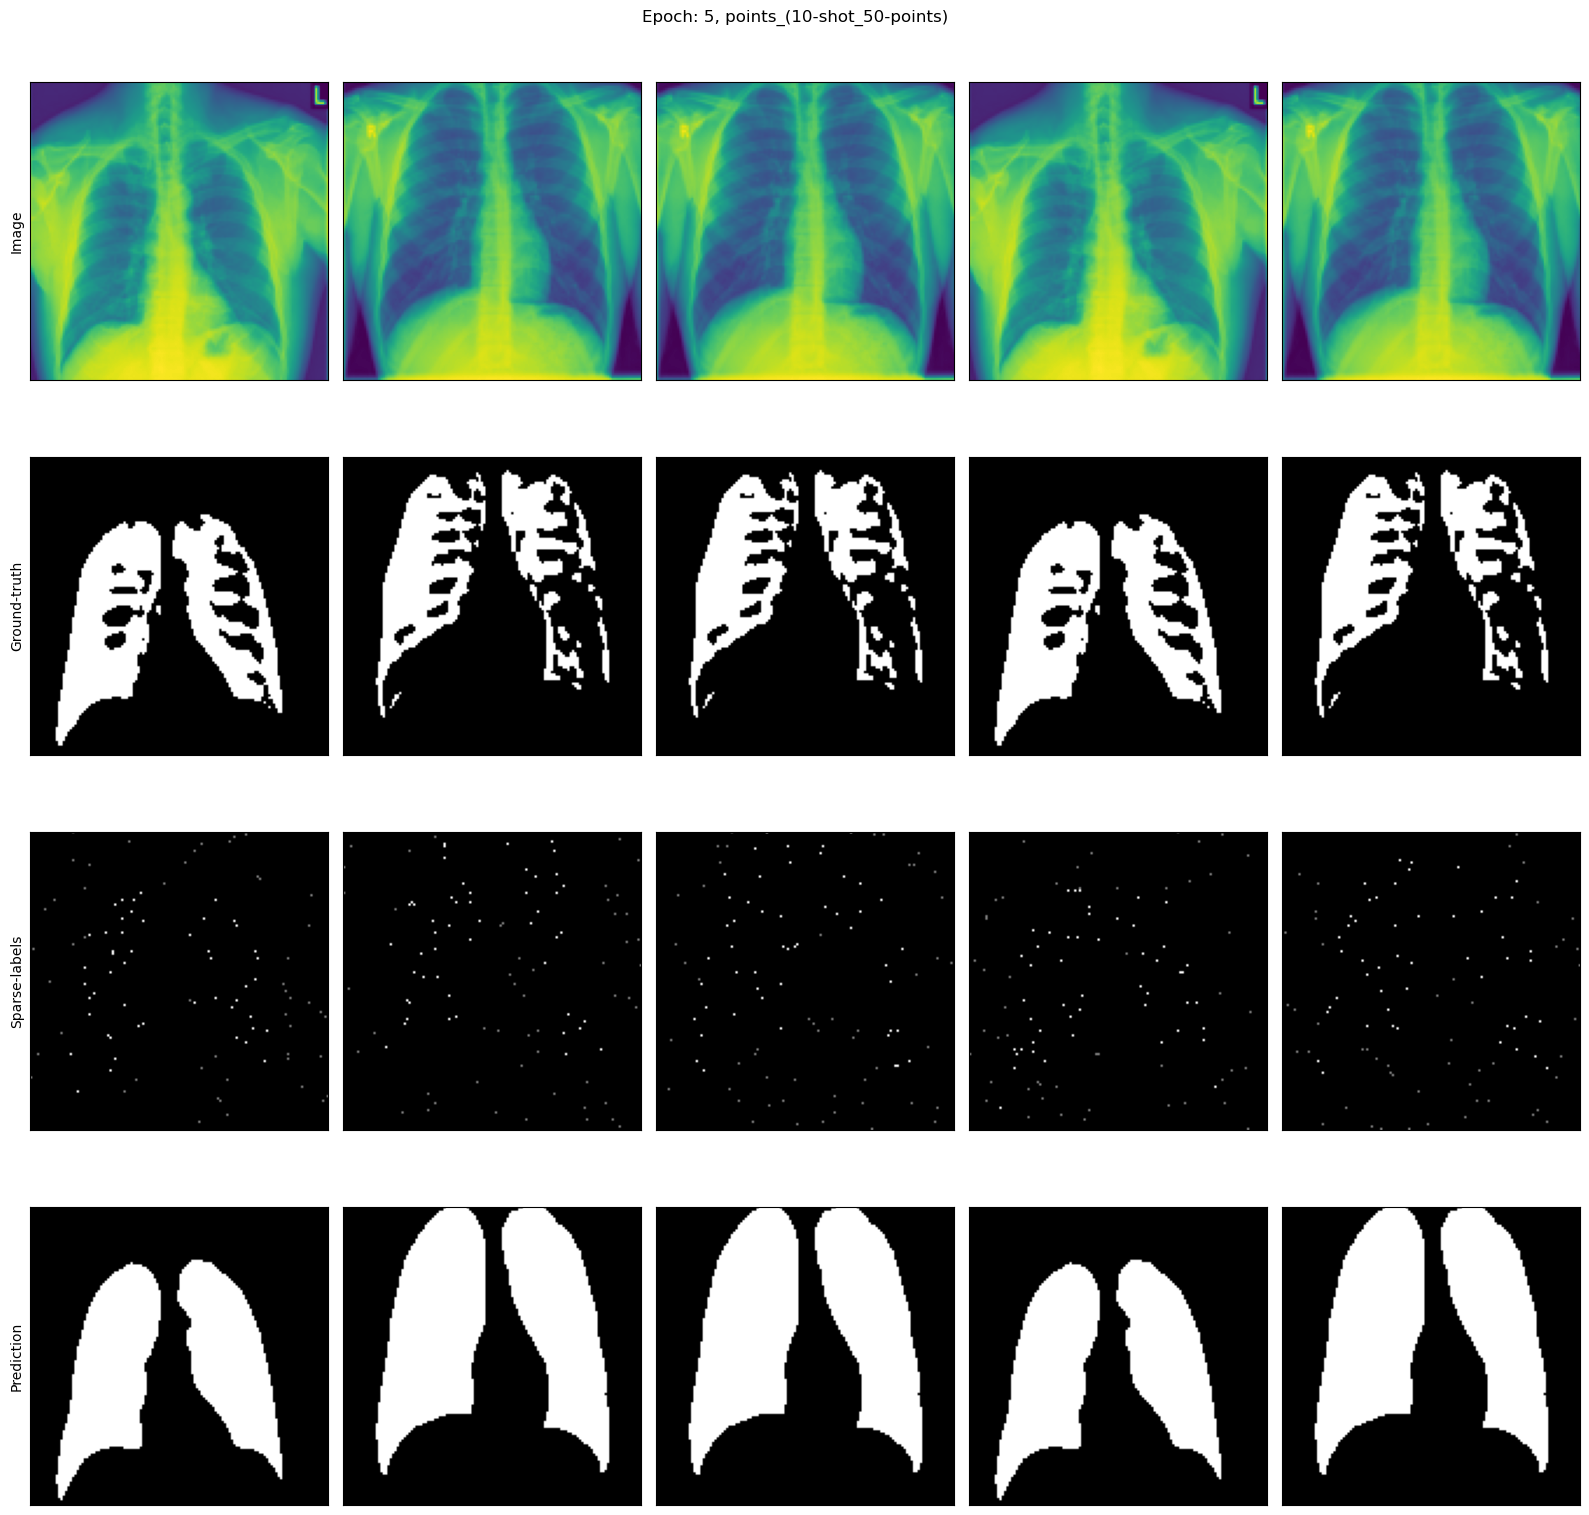

--------------------------------------------------------------------
Jaccard test "points_(10-shot_50-points)" 5/10: 55.94
--------------------------------------------------------------------
Tuning epoch 6/10
Tuning epoch 7/10
Tuning epoch 8/10
Tuning epoch 9/10
Tuning epoch 10/10


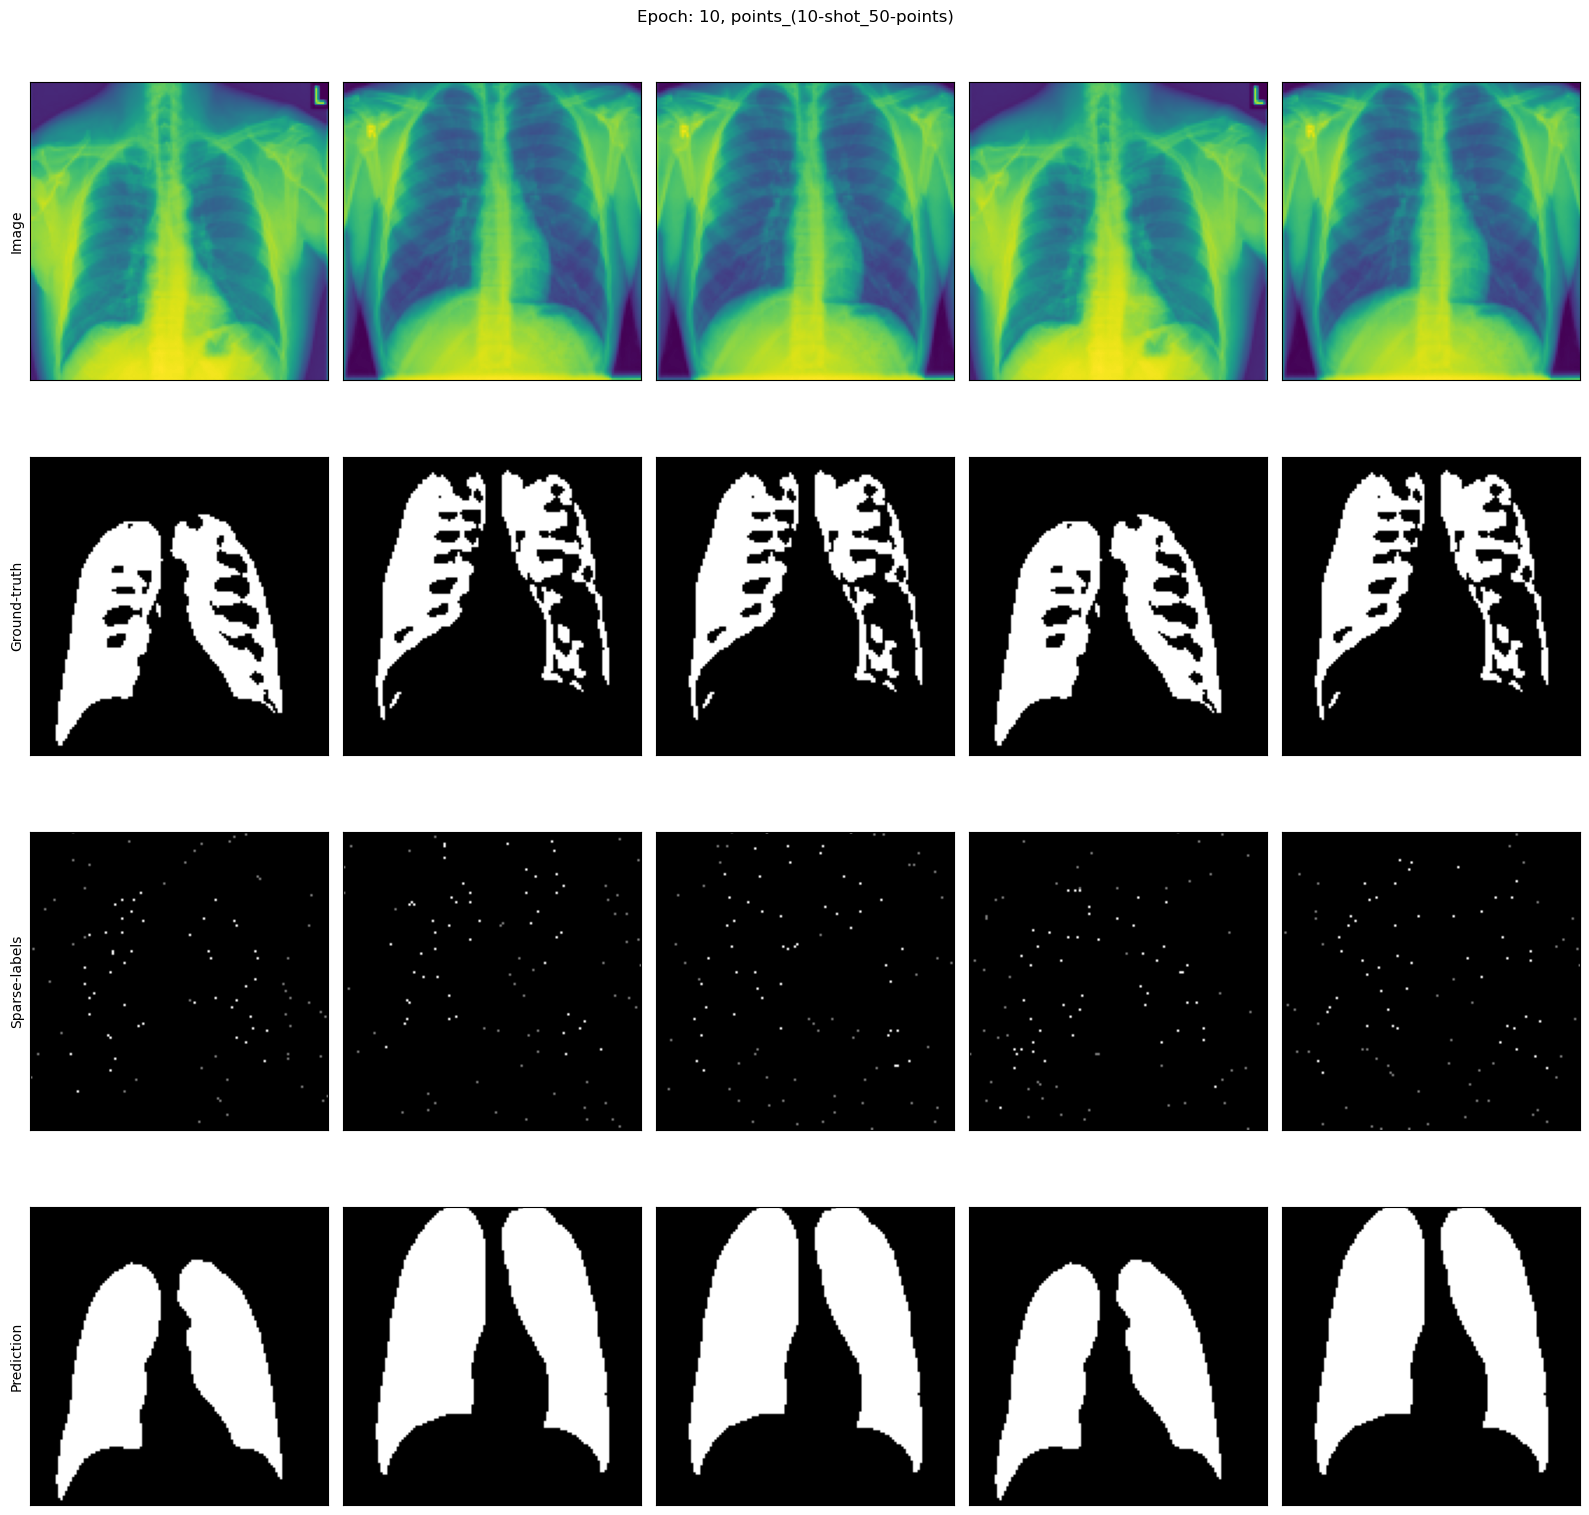

--------------------------------------------------------------------
Jaccard test "points_(10-shot_50-points)" 10/10: 59.30
--------------------------------------------------------------------
    Evaluating 'grid' (10-shot, 5-spacing)...
Tuning epoch 1/10
Tuning epoch 2/10
Tuning epoch 3/10
Tuning epoch 4/10
Tuning epoch 5/10


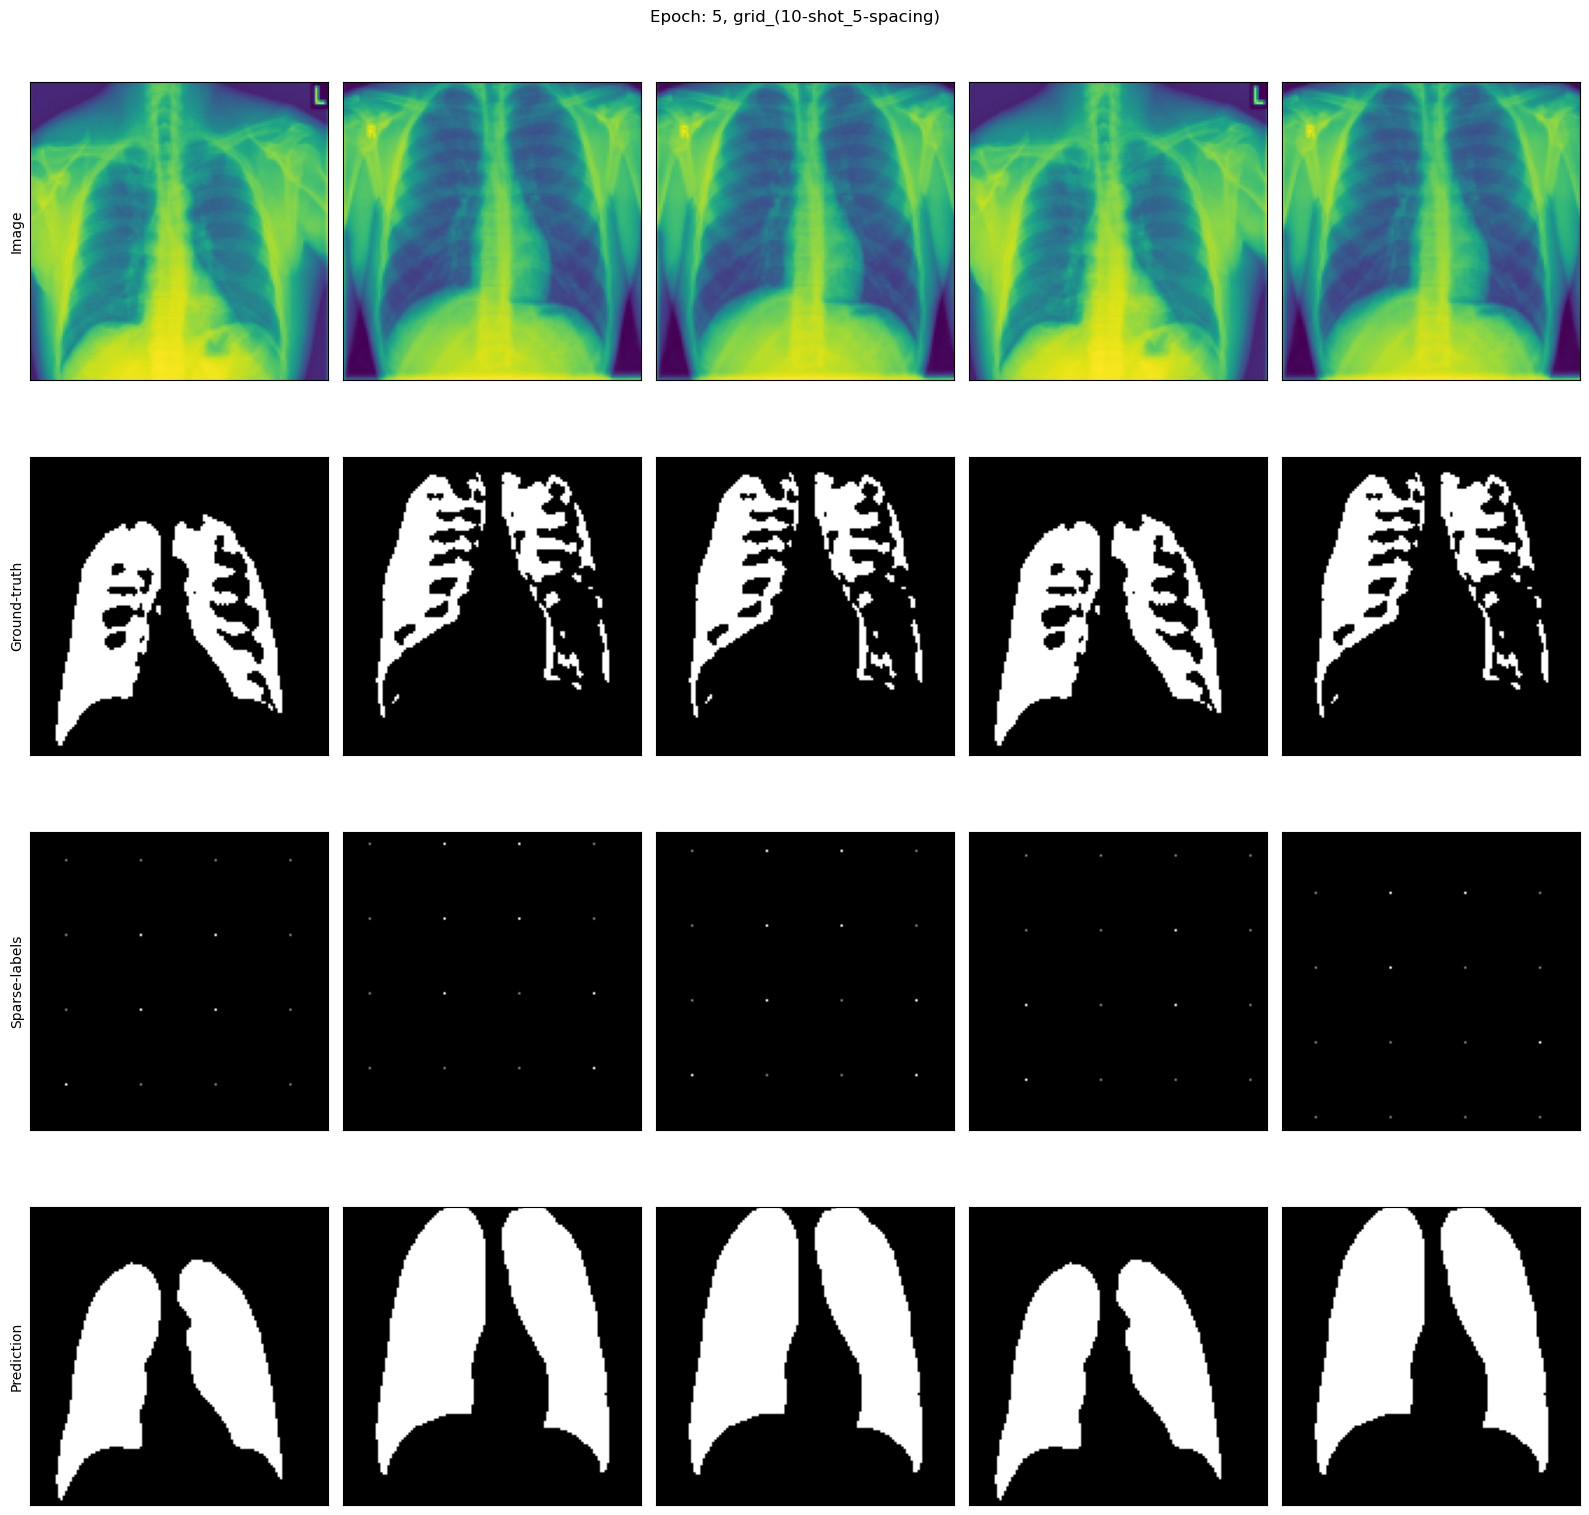

--------------------------------------------------------------------
Jaccard test "grid_(10-shot_5-spacing)" 5/10: 53.62
--------------------------------------------------------------------
Tuning epoch 6/10
Tuning epoch 7/10
Tuning epoch 8/10
Tuning epoch 9/10
Tuning epoch 10/10


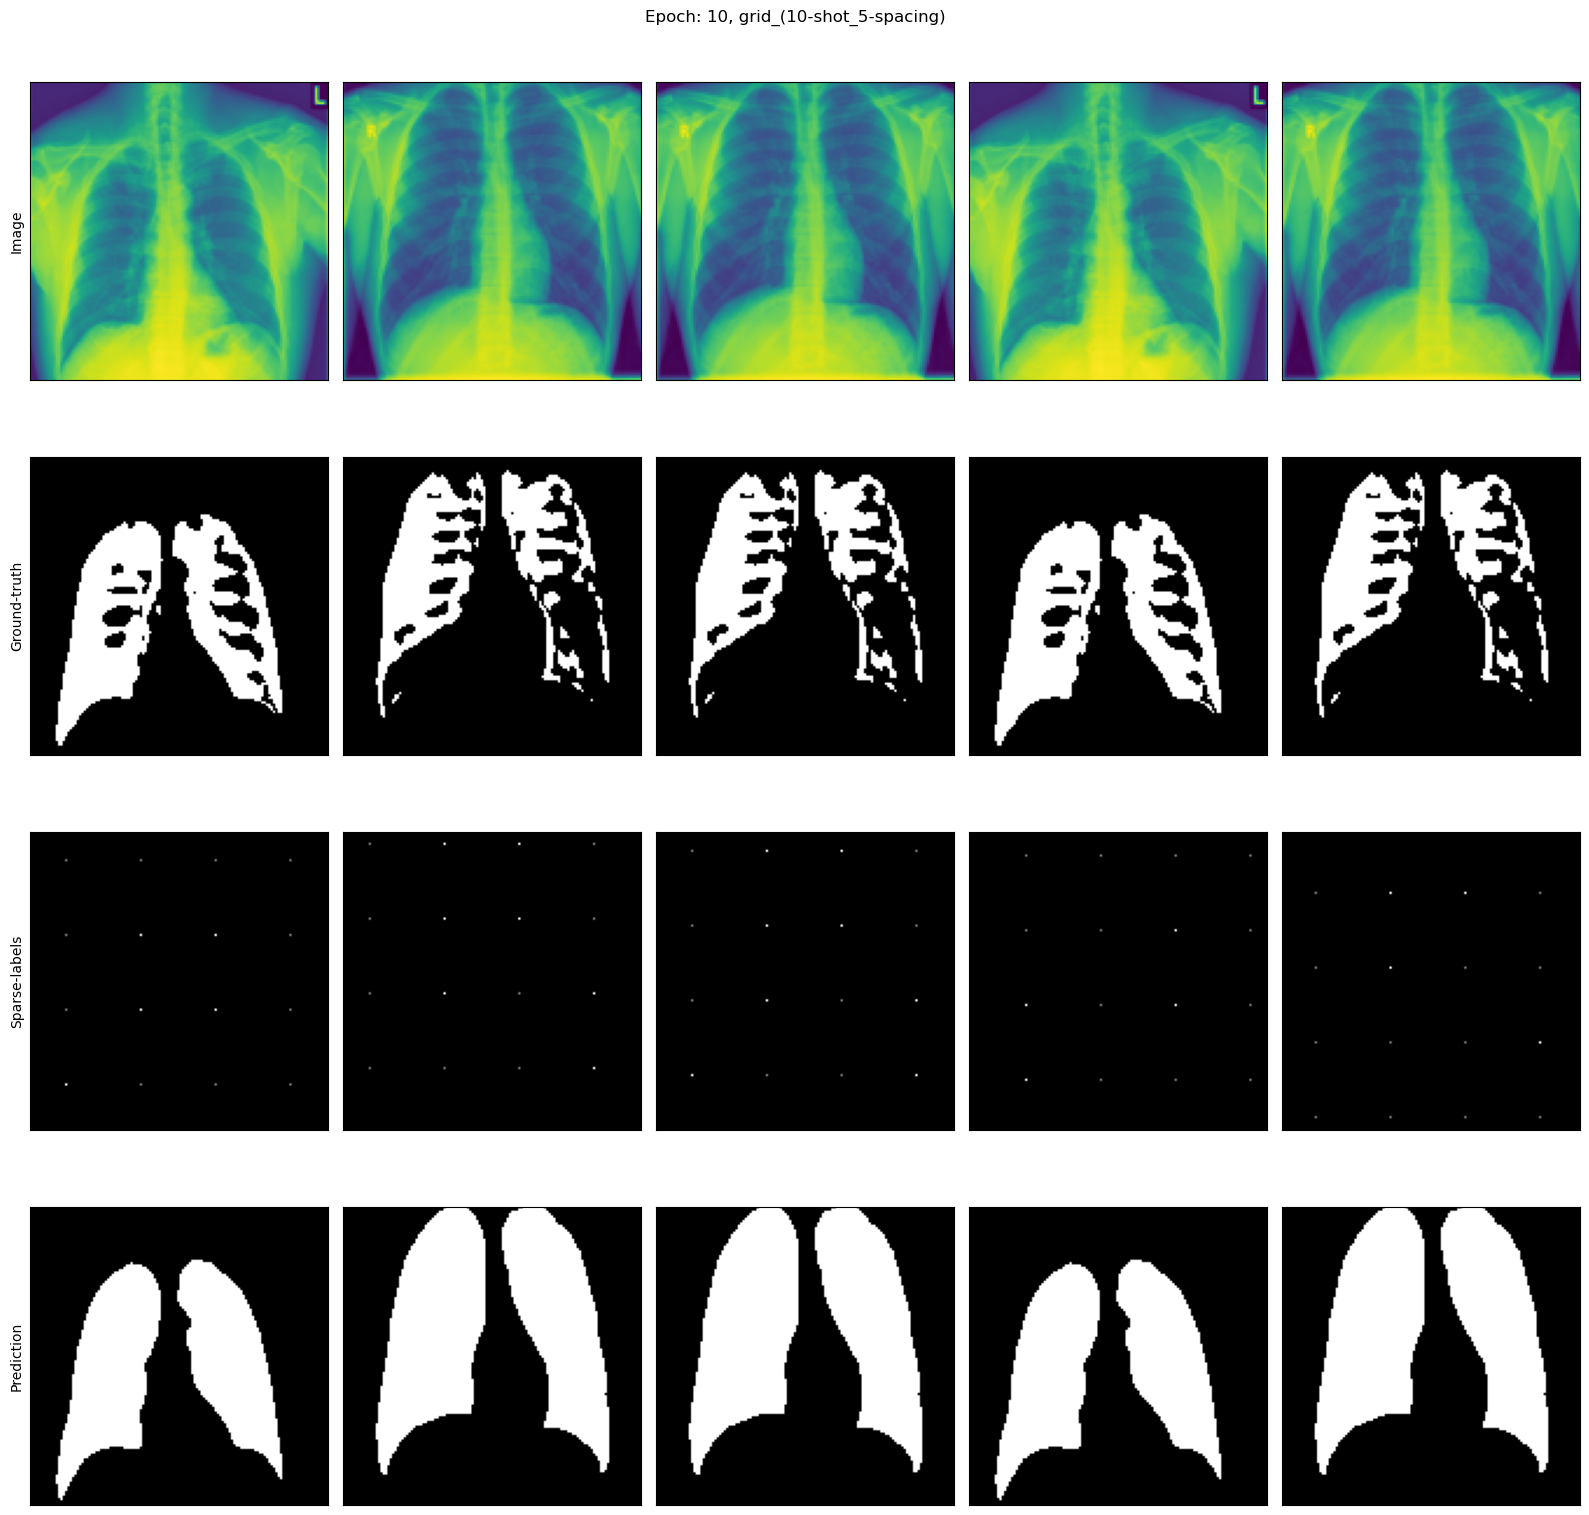

--------------------------------------------------------------------
Jaccard test "grid_(10-shot_5-spacing)" 10/10: 56.21
--------------------------------------------------------------------
    Evaluating 'dense' (10-shot)...
Tuning epoch 1/10
Tuning epoch 2/10
Tuning epoch 3/10
Tuning epoch 4/10
Tuning epoch 5/10


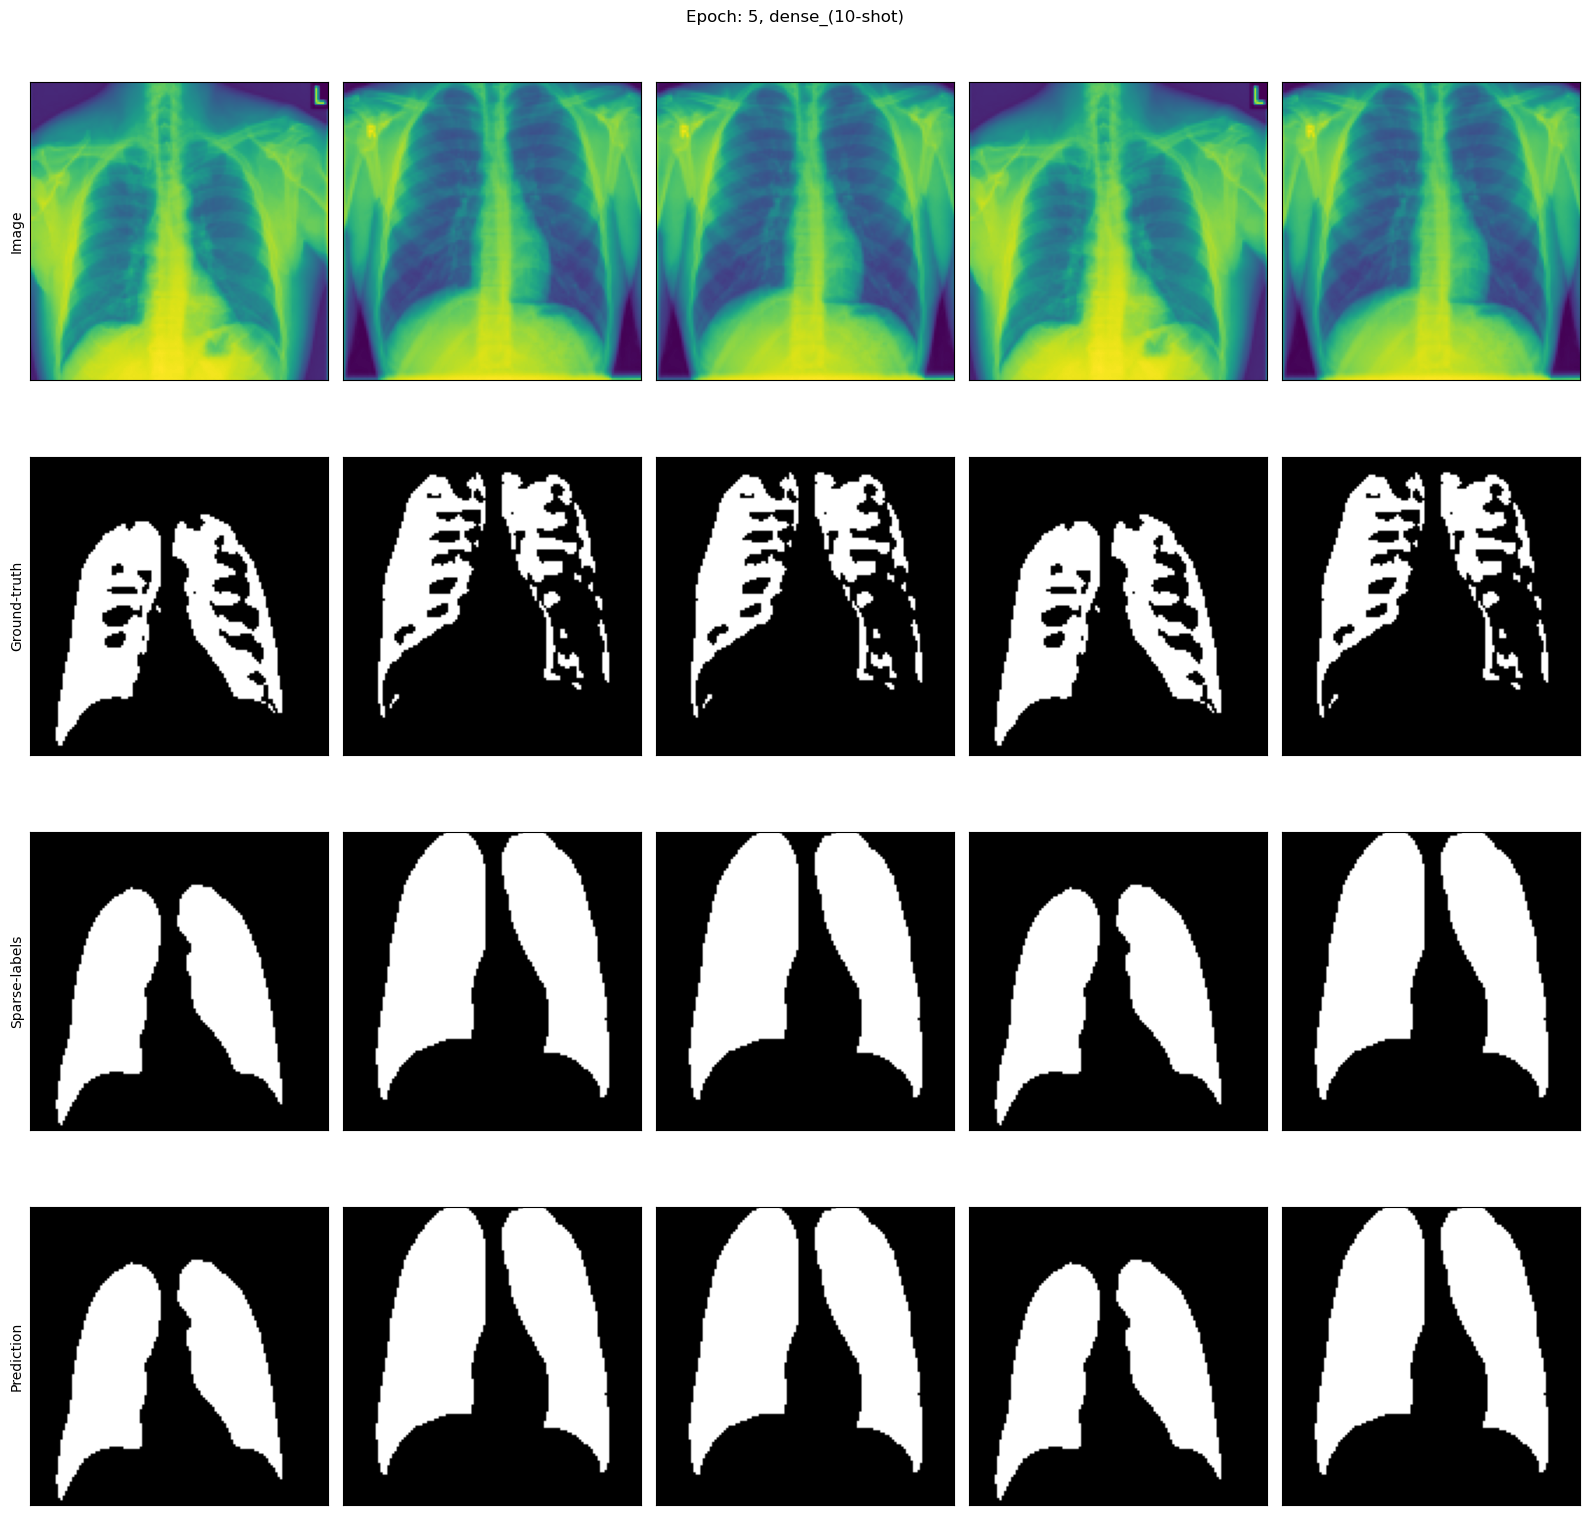

--------------------------------------------------------------------
Jaccard test "dense_(10-shot)" 5/10: 55.62
--------------------------------------------------------------------
Tuning epoch 6/10
Tuning epoch 7/10
Tuning epoch 8/10
Tuning epoch 9/10
Tuning epoch 10/10


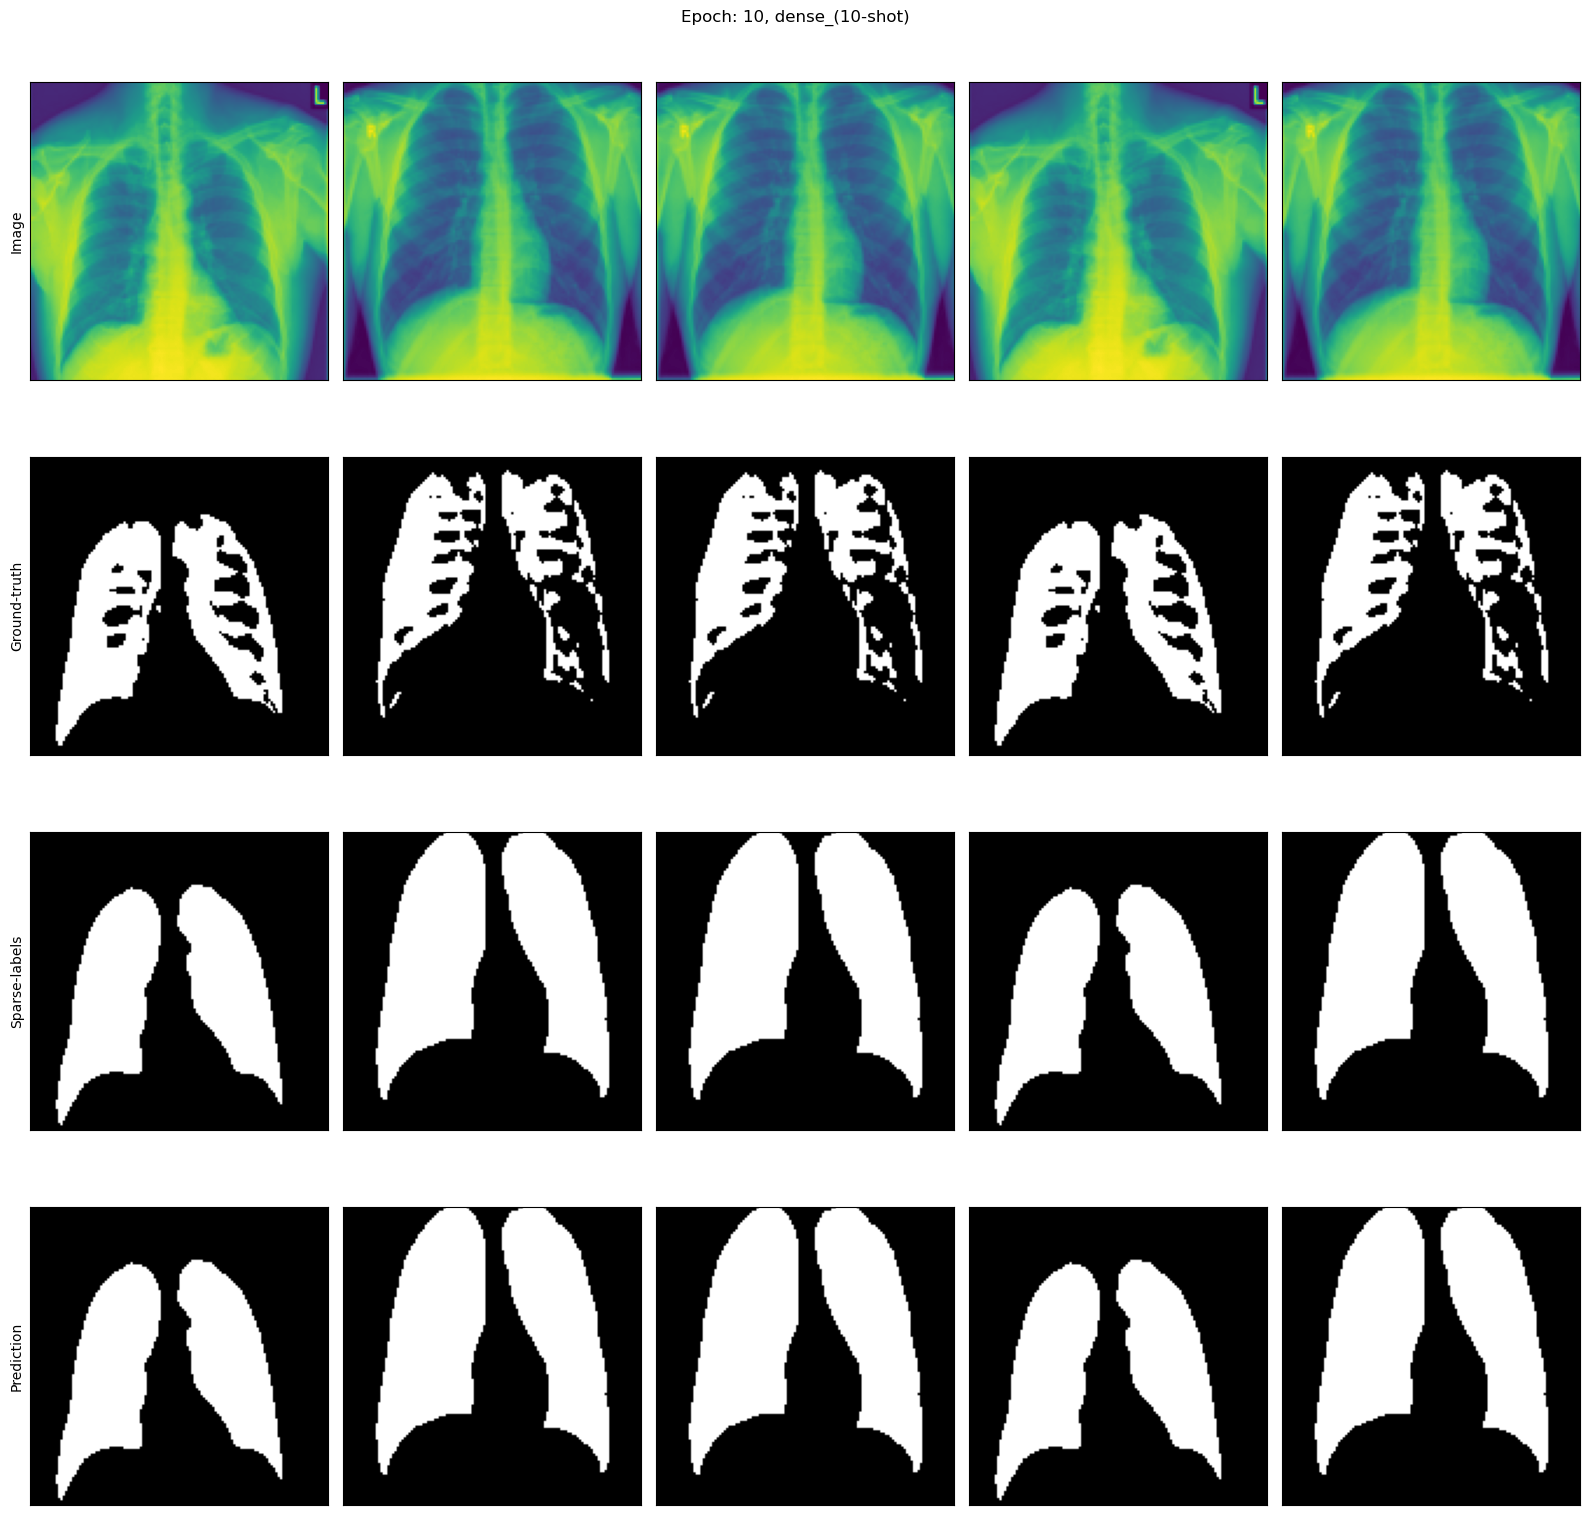

--------------------------------------------------------------------
Jaccard test "dense_(10-shot)" 10/10: 58.06
--------------------------------------------------------------------


In [16]:
list_shots = [10]
list_sparsity_points = [50]
list_sparsity_grid = [5]

# Get DataLoaders
loaders_dict = get_tune_loaders(list_shots, 
                                list_sparsity_points, 
                                list_sparsity_grid,
                                fold, resize_to, args)

# Run tuning experiments
run_sparse_tuning(loaders_dict, net, optimizer, args, model_weights, False)

In [42]:
torch.save(temp_var["data_tr"][0], "./stored_var/tr_img.pt")
torch.save(temp_var["data_tr"][1], "./stored_var/tr_msk.pt")
torch.save(temp_var["data_tr"][2], "./stored_var/tr_sparse_msk.pt")
torch.save(temp_var["pred_tr"], "./stored_var/tr_pred.pt")

torch.save(temp_var["data_ts"][0], "./stored_var/ts_img.pt")
torch.save(temp_var["data_ts"][1], "./stored_var/ts_msk.pt")
torch.save(temp_var["data_ts"][2], "./stored_var/ts_sparse_msk.pt")
torch.save(temp_var["pred_ts"], "./stored_var/ts_pred.pt")